# Stiffness in each Step

This Jupyter simply shows that Opensees returns current stiffness of the system at each step!

By: Bijan Sayyafzadeh (B.sayyaf@yahoo.com)

<IPython.core.display.Javascript object>


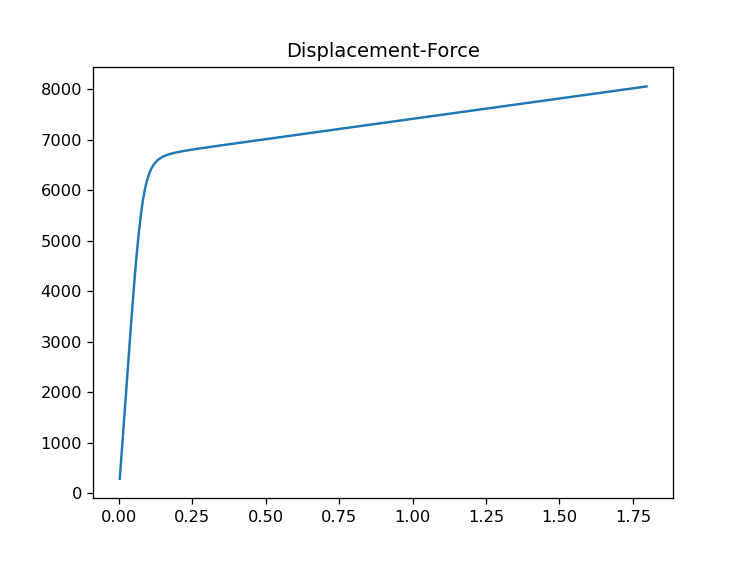

<IPython.core.display.Javascript object>


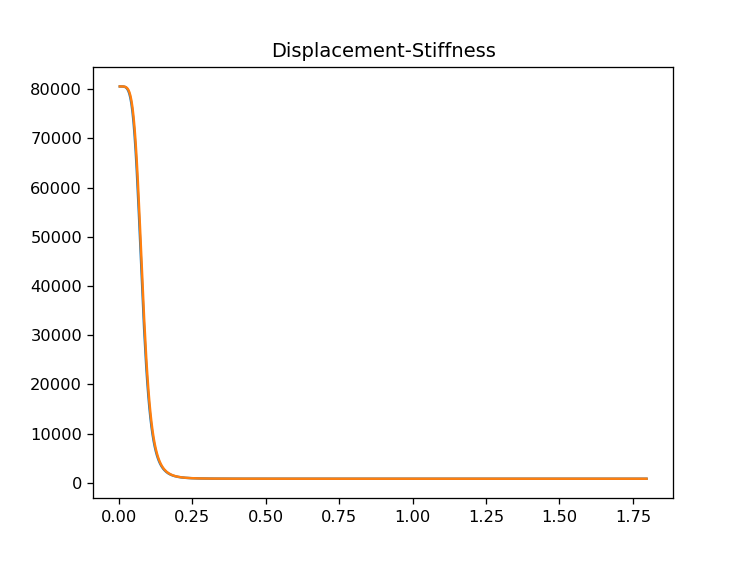

In [43]:

import openseespy.opensees as op
import opsvis as opv
import eSEESminiPy as slv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

#Model
op.wipe()

op.model('basic', '-ndm', 2, '-ndf', 3) 

L = 36   
op.node(1, 0.0, 0.0)
op.node(2, L, 0.0 )

op.fix(1, 1, 1, 1)


# MATERIAL
MatTag = 1  

Fy = 66.8          # STEEL yield stress
Es = 29000.0       # modulus of steel
Bs = 0.01          # strain-hardening ratio 
R0 = 5.0          # control the transition from elastic to plastic branches
cR1 = 0.925        # control the transition from elastic to plastic branches
cR2 = 0.15         # control the transition from elastic to plastic branches
epsyP=Fy/Es

op.uniaxialMaterial('Steel02', MatTag, Fy, Es, Bs, R0,cR1,cR2) 
# op.uniaxialMaterial('ElasticPP', MatTag, Es, epsyP)



#Section
H = 5.0 
B = 5.0 

nfY = 16   
nfZ = 16            

ColSecTag = 1
op.section('Fiber', ColSecTag)
op.patch('quad', MatTag, nfZ, nfY, -H,B, -H,-B, H,-B, H,B) # Define the concrete patch
ColTransfTag = 1
op.geomTransf('Linear', ColTransfTag)
numIntgrPts = 5
eleTag = 1
integrationTag=1
op.beamIntegration('Legendre', integrationTag, ColSecTag, numIntgrPts)
op.element('dispBeamColumn', eleTag, 1, 2, ColTransfTag, integrationTag)

#DrawModel
# slv.drawModel()


#Analysis 

maxNumIter = 6
Tol = 1e-8

op.timeSeries('Linear', 2)
op.pattern('Plain', 200, 2)
op.load(2, 1.0, 0.0,0.0)

op.wipeAnalysis()
op.constraints('Plain')
op.numberer('Plain')
op.system('FullGeneral')
op.test('NormDispIncr', Tol, maxNumIter)
op.algorithm('KrylovNewton','-initial')

Dmax = 0.05*L
Dincr = 0.0001*L
IDctrlNode = 2
IDctrlDOF = 1
op.integrator('DisplacementControl', IDctrlNode, IDctrlDOF, Dincr)
op.analysis('Static')



Nsteps =  int(Dmax/ Dincr)
u2=[]
F1=[]
Ks=[]
Kh=[]


f1=0
u1=0

for i in range(Nsteps):
    ok = op.analyze(1)
    u2.append( op.nodeDisp(2, 1))
    op.reactions()
    F1.append(op.nodeReaction(1,1)*-1)
    Kh.append(abs(op.nodeReaction(1,1)-f1)/(op.nodeDisp(2, 1)-u1))
    f1=op.nodeReaction(1,1)
    u1=op.nodeDisp(2, 1)
    
#     op.integrator('GimmeMCK',0.0,0.0,1.0)
#     op.analyze(1)
    N = op.systemSize() # Has to be done after analyze
    K=op.printA('-ret')
    Ks.append(K[0])
#     K = np.array(K)
#     K.shape = (N,N)
#     print(K)
    op.integrator('DisplacementControl', IDctrlNode, IDctrlDOF, Dincr)

#Print Results
plt.figure()
plt.plot(u2,F1);
plt.title('Displacement-Force')
plt.figure()
plt.plot(u2,Ks)
plt.plot(u2,Kh)
plt.title('Displacement-Stiffness');
